## Module overview
Regarding particle data deposition onto grids in 2d or 3d, the `punkt` package offers multiple `deposition` functions.\
The higher the order, the more adaptive (and the more costly) the deposition strategy becomes.

| Description                 | Function                        |
|:----------------------------|---------------------------------|
| Nearest-Grid-Point-Assignment (NGP)         | `p2g()`              |
| Cloud-in-Cell (cic)         | `cic_deposition()`              |
| Adaptive cic (adaptive cic) | `cic_deposition()`              |
| Isotropic Quintic Kernel    | `isotropic_kernel_deposition()` |
| Anisotropic Quintic Kernel  | `anisotropic_kernel_deposition()` |

Generally, all functions share the following inputs:

| Name         | Description                                                    | Shape                |
|:-------------|:---------------------------------------------------------------|---------------------:|
| `positions`  | particle positions                                             | (N, dim)             |
| `quantities` | quantities can be stacked in the channels dimension            | (N, num_quantities)  |
| `averaged`   | whether the quantity in a cell is averaged (e.g. temperature is averaged while mass is additive)                     | (num_quantities,)    |
| `extent`     | domain extent in simulation units e.g. (0, boxsize)            | (2,)                 |
| `gridnum`    | number of grid cells to use, same for each dimension           | int                  |
| `periodic`   | whether to account for periodic boundary conditions            | True / False         |

### Strategies overview
`punkt` has the following deposition strategies: `cic`, `adaptive cic`, `isotropic` and `anisotropic`.

### Simple CIC
Simple cic spreads the particle quantity over the neighbouring overlapping cells. The particle "cloud" is a tophat kernel with the same compact support (i.e. size) as the grid cells.

### Adaptive CIC
One can adapt the tophat kernel size of each particle trough the argument `pcellsizesHalf` of shape `(N,)` of each particle.
The tophat kernel will be adaptively changed according to these sizes like in the sample image below.\
**NN search**: Say we want to assign to `pcellsizesHalf` the distance to the **k**'th nearest neighbor of each particle. One can do so, by setting `num_nn`.\
The following image displays the behaviour.

<img src="plots/cic_adaptive.png" width="300" height="300" align="center" />

### Isotropic kernel
For the isotropic kernel deposition, one can adopt a higher order sph-kernel (here a quintic kernel) that weighs the contribution between neighbouring cells.\
The kernel scaling size is typically defined as the smoothing length `h`, while the kernel compact support extends to `2h`.\
To compute the smoothing length, the code adopts a nearest neighbor search and assigns the smoothing length as the distance to the `nn`-th neighbor.\
This can be computed with the `compute_hsm(pos, nn, boxsize)` function from the `sph_modules` library.

`pos`= particle positions, `nn`= number of nearest neighbors, `boxsize`= boxsize of the periodic domain

### Anisotropic kernel
The next higher order is to allow the smoothing length to vary in different directions, i.e. instead of a smoothing length, the smoothing **tensor** $\text{H}$ is computed.\
Following (https://arxiv.org/abs/2106.08870) $\text{H}$ can be computed using the `compute_hsm_tensor(pos, masses, nn, boxsize)` function from the `sph_modules` library.\
It performs the following operations

+ the `nn` nearest neighbors are identified defining a cluster $C$

+ the clusters covariance tensor is computed
    $$\Sigma_C = M_C^{-1} \sum_C m_j (r_j -r_C) \otimes (r_j -r_C)$$
    
+ since $\text{H} = \Sigma_C^{1/2}$, compute the eigenvectors $(e_1, e_2, e_3)$ and -values $(h_1, h_2, h_3)$ of $\text{H}$

    + **3d**: the anisotropic kernel contributions are then computed as 
    $$W_H = (\det \text{H})^{-1} K(\xi_r)$$ with $$\xi_r =\sqrt{\xi_1^2+\xi_2^2+\xi_3^2}, \quad \xi_i = \frac{\mathbf{e}_j\cdot\mathbf{r}}{h_j}$$

    + **2d**: in the case of a 2d-projection, $\text{H}$ is first projected onto the specified plane via a projection matrix and \
        the eigenvectors and -values of $\text{H}_{2d}$ are used to evaulate the 2d kernel where $\xi_r =\sqrt{\xi_1^2+\xi_2^2}$ \
        To change the projection, the `plane` keyword can be set to either `xy`, `yz` or `xz`.

In [1]:
import torch # this first torch import is CRUCIAL for finding the libtorch files!
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt

from sph_lib.deposition import (compute_hsm, 
                                compute_hsm_tensor, 
                                project_hsm_tensor_to_2d, 
                                p2g
                                )

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
ds = pn.load('../../../data/snapshot_176_128.hdf5')

/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:635: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)


In [3]:
# simulation information
periodic = True
boxsize  = 15000
extent   = np.array([0, boxsize])

# grid information
NN       = 8
gridnum  = 50

In [4]:
# needed fields
pos      = ds.gas['pos']
masses   = ds.gas['mass']
temp     = ds.gas['temp']
metals   = ds.gas['metals'][:, 0]

# IMPORTANT: hsm (tensor) needs to be computed from the 3d distribution (unless the simulation is 2d)!!
hsm = compute_hsm(pos, NN, boxsize)[0]
hmat, eλ, ev = compute_hsm_tensor(pos, masses, NN, boxsize)

# stack all quantities to deposit
quantities = np.stack([masses, metals, temp], axis=-1); print(quantities.shape)

# do we need to average the deposited quantities or not?
averaged   = [False, True, True]

/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:469: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


(2087272, 3)


#### 2D case

In [5]:
mask = np.logical_and(pos[:, -1] > 0,
                      pos[:, -1] < 3000)

pos_masked          = pos[mask][:, :2]
masses_masked       = masses[mask]
hsm_masked          = hsm[mask]
hmat_masked        = hmat[mask]
quantities_masked   = quantities[mask]
hmat_2d, eλ_2d, ev_2d = project_hsm_tensor_to_2d(hmat_masked, plane=(0, 1)) 

kwargs = {'positions': pos_masked, 
          'quantities': quantities_masked, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

In [7]:
fields_ngp = p2g(**kwargs, method='ngp')
fields_cic = p2g(**kwargs, method='cic')
fields_tsc = p2g(**kwargs, method='tsc')

fields_ngp_cpp = p2g(**kwargs, method='ngp', accelerator='cpp')
fields_cic_cpp = p2g(**kwargs, method='cic', accelerator='cpp')
fields_tsc_cpp = p2g(**kwargs, method='tsc', accelerator='cpp')

fields_cic_ada_cpp = p2g(**kwargs, method='cic_adaptive', accelerator='cpp', num_nn=NN)
fields_tsc_ada_cpp = p2g(**kwargs, method='tsc_adaptive', accelerator='cpp', num_nn=NN)

fields_sph_iso_cpp_1   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='gaussian')
fields_sph_iso_cpp_2   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='super_gaussian')
fields_sph_iso_cpp_3   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='cubic')
fields_sph_iso_cpp_4   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='quintic')
fields_sph_iso_cpp_5   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c2')
fields_sph_iso_cpp_6   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c4')
fields_sph_iso_cpp_7   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c6')

fields_sph_aniso_cpp_1 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='gaussian')
fields_sph_aniso_cpp_2 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='super_gaussian')
fields_sph_aniso_cpp_3 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='cubic')
fields_sph_aniso_cpp_4 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='quintic')
fields_sph_aniso_cpp_5 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='wendland_c2')
fields_sph_aniso_cpp_6 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='wendland_c4')
fields_sph_aniso_cpp_7 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='wendland_c6')

/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/2010199705.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[3, i].imshow(np.log10(fields_ngp_cpp)[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/2010199705.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[4, i].imshow(np.log10(fields_cic_cpp)[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/2010199705.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[5, i].imshow(np.log10(fields_cic_ada_cpp)[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/2010199705.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally)

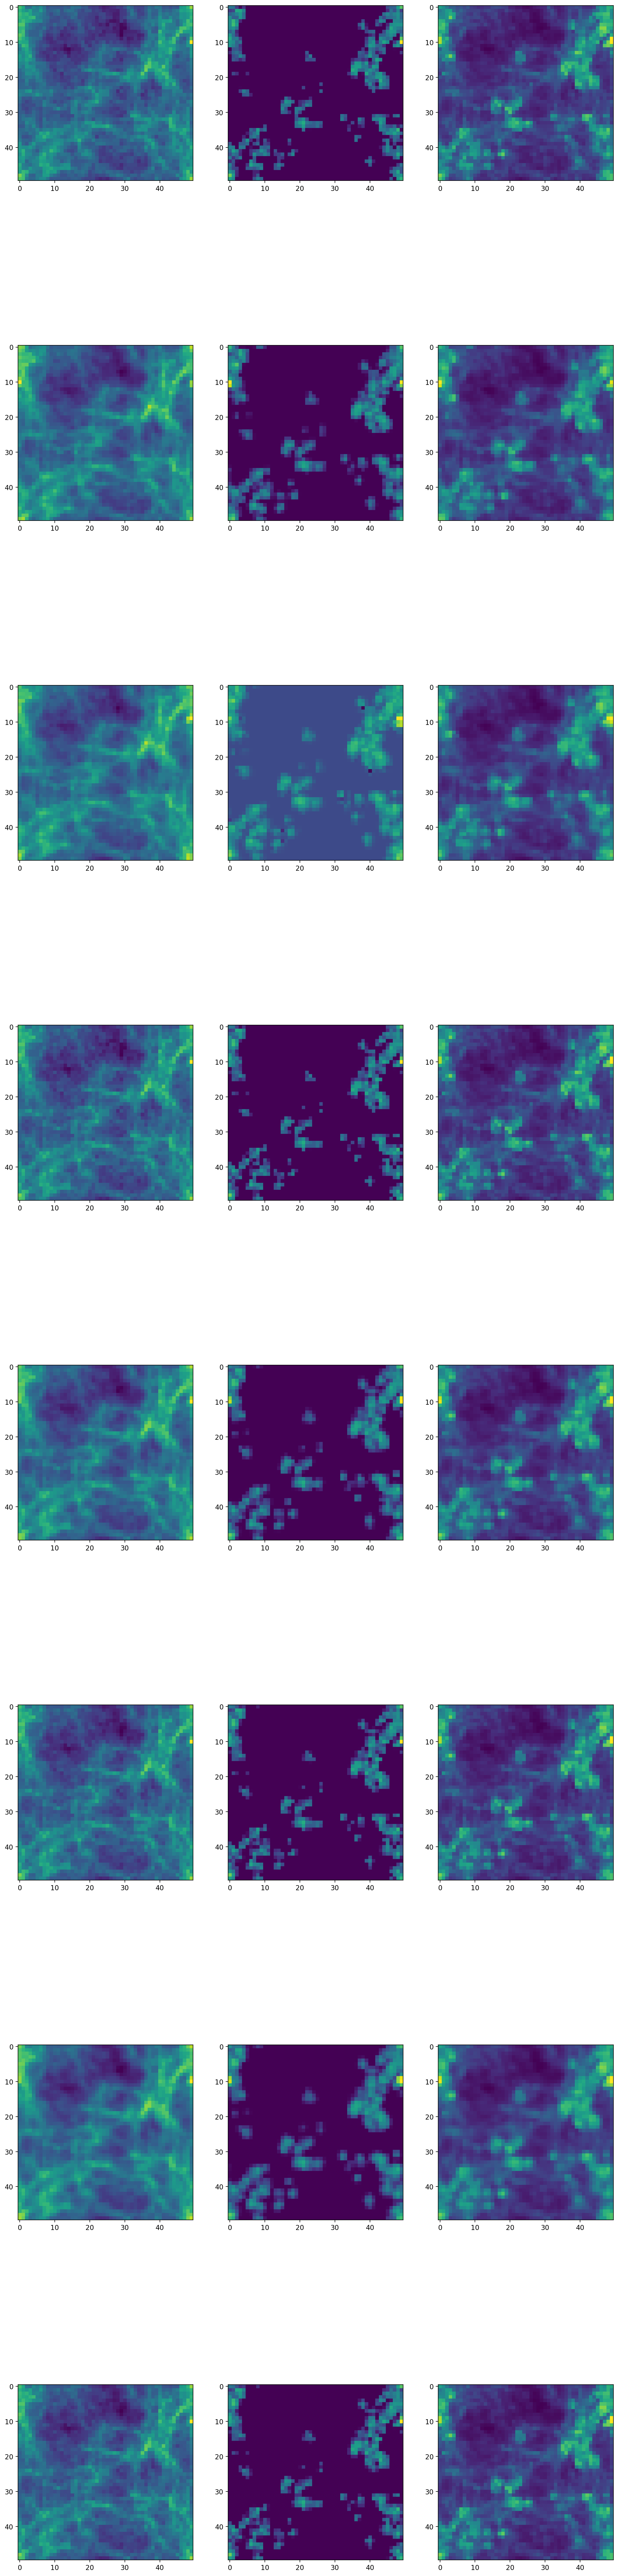

In [8]:
fig, ax = plt.subplots(8, quantities.shape[1], figsize=(16, 72))
for i in range(quantities.shape[1]):
    ax[0, i].imshow(np.log10(fields_ngp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[1, i].imshow(np.log10(fields_cic)[:, :, i])

for i in range(quantities.shape[1]):
    ax[2, i].imshow(np.log10(fields_tsc)[:, :, i])

for i in range(quantities.shape[1]):
    ax[3, i].imshow(np.log10(fields_ngp_cpp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[4, i].imshow(np.log10(fields_cic_cpp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[5, i].imshow(np.log10(fields_cic_ada_cpp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[6, i].imshow(np.log10(fields_tsc_cpp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[7, i].imshow(np.log10(fields_tsc_ada_cpp)[:, :, i])
plt.show()

/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/1190146555.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0, i].imshow(np.log10(fields_sph_iso_cpp_1)[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/1190146555.py:6: RuntimeWarning: invalid value encountered in log10
  ax[1, i].imshow(np.log10(fields_sph_iso_cpp_2)[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/1190146555.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[1, i].imshow(np.log10(fields_sph_iso_cpp_2)[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/1190146555.py:9: RuntimeWarning: divide by zero encountered in log10
  ax[2, i].imshow(np.log10(fields_sph_iso_cpp_3)[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70

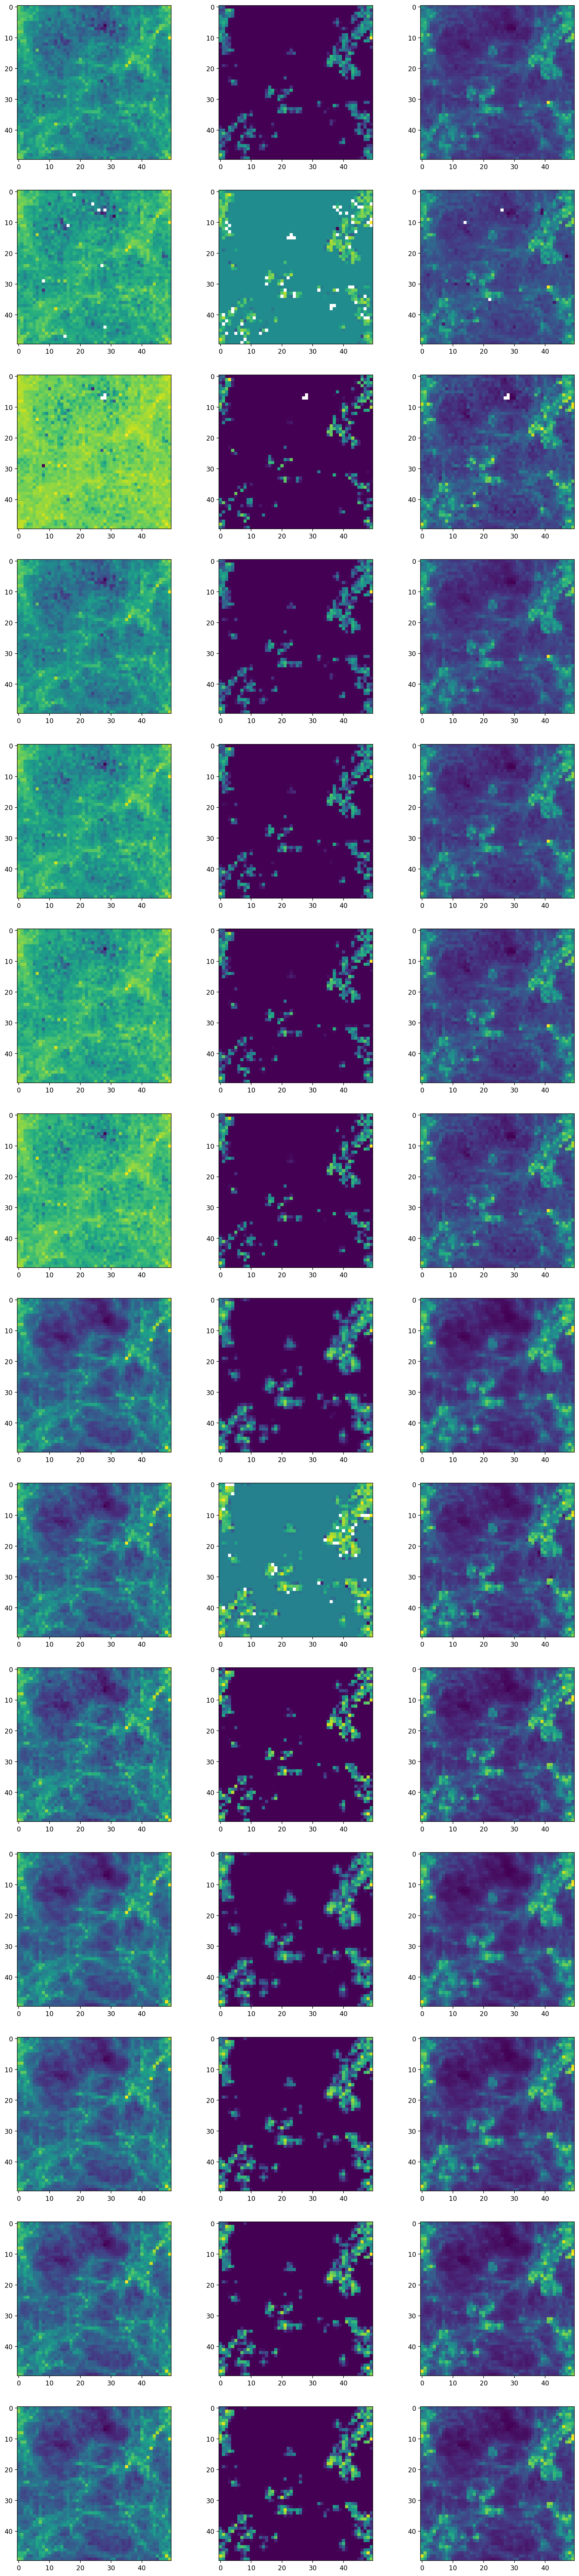

In [9]:
fig, ax = plt.subplots(14, quantities.shape[1], figsize=(16, 72))
for i in range(quantities.shape[1]):
    ax[0, i].imshow(np.log10(fields_sph_iso_cpp_1)[:, :, i])

for i in range(quantities.shape[1]):
    ax[1, i].imshow(np.log10(fields_sph_iso_cpp_2)[:, :, i])

for i in range(quantities.shape[1]):
    ax[2, i].imshow(np.log10(fields_sph_iso_cpp_3)[:, :, i])

for i in range(quantities.shape[1]):
    ax[3, i].imshow(np.log10(fields_sph_iso_cpp_4)[:, :, i])

for i in range(quantities.shape[1]):
    ax[4, i].imshow(np.log10(fields_sph_iso_cpp_5)[:, :, i])

for i in range(quantities.shape[1]):
    ax[5, i].imshow(np.log10(fields_sph_iso_cpp_6)[:, :, i])

for i in range(quantities.shape[1]):
    ax[6, i].imshow(np.log10(fields_sph_iso_cpp_7)[:, :, i])


for i in range(quantities.shape[1]):
    ax[7, i].imshow(np.log10(fields_sph_aniso_cpp_1)[:, :, i])

for i in range(quantities.shape[1]):
    ax[8, i].imshow(np.log10(fields_sph_aniso_cpp_2)[:, :, i])

for i in range(quantities.shape[1]):
    ax[9, i].imshow(np.log10(fields_sph_aniso_cpp_3)[:, :, i])

for i in range(quantities.shape[1]):
    ax[10, i].imshow(np.log10(fields_sph_aniso_cpp_4)[:, :, i])

for i in range(quantities.shape[1]):
    ax[11, i].imshow(np.log10(fields_sph_aniso_cpp_5)[:, :, i])

for i in range(quantities.shape[1]):
    ax[12, i].imshow(np.log10(fields_sph_aniso_cpp_6)[:, :, i])

for i in range(quantities.shape[1]):
    ax[13, i].imshow(np.log10(fields_sph_aniso_cpp_7)[:, :, i])
plt.show()

#### 3D case

In [11]:
kwargs = {'positions': pos, 
          'quantities': quantities, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

In [12]:
fields_ngp = p2g(**kwargs, method='ngp')
fields_cic = p2g(**kwargs, method='cic')
fields_tsc = p2g(**kwargs, method='tsc')

fields_ngp_cpp = p2g(**kwargs, method='ngp', accelerator='cpp')
fields_cic_cpp = p2g(**kwargs, method='cic', accelerator='cpp')
fields_tsc_cpp = p2g(**kwargs, method='tsc', accelerator='cpp')

fields_cic_ada_cpp = p2g(**kwargs, method='cic_adaptive', accelerator='cpp', num_nn=NN)
fields_tsc_ada_cpp = p2g(**kwargs, method='tsc_adaptive', accelerator='cpp', num_nn=NN)

fields_sph_iso_cpp_1 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='gaussian')
fields_sph_iso_cpp_2 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='super_gaussian')
fields_sph_iso_cpp_3 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='cubic')
fields_sph_iso_cpp_4 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='quintic')
fields_sph_iso_cpp_5 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c2')
fields_sph_iso_cpp_6 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c4')
fields_sph_iso_cpp_7 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c6')

fields_sph_aniso_cpp_1 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='gaussian')
fields_sph_aniso_cpp_2 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='super_gaussian')
fields_sph_aniso_cpp_3 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='cubic')
fields_sph_aniso_cpp_4 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='quintic')
fields_sph_aniso_cpp_5 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c2')
fields_sph_aniso_cpp_6 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c4')
fields_sph_aniso_cpp_7 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c6')

/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/2782788083.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[3, i].imshow(np.log10(fields_ngp_cpp.mean(axis=0))[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/2782788083.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[4, i].imshow(np.log10(fields_cic_cpp.mean(axis=0))[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/2782788083.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[5, i].imshow(np.log10(fields_cic_ada_cpp.mean(axis=0))[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/2782788083.py:21: DeprecationWarning: __array_wrap__ must accept context and

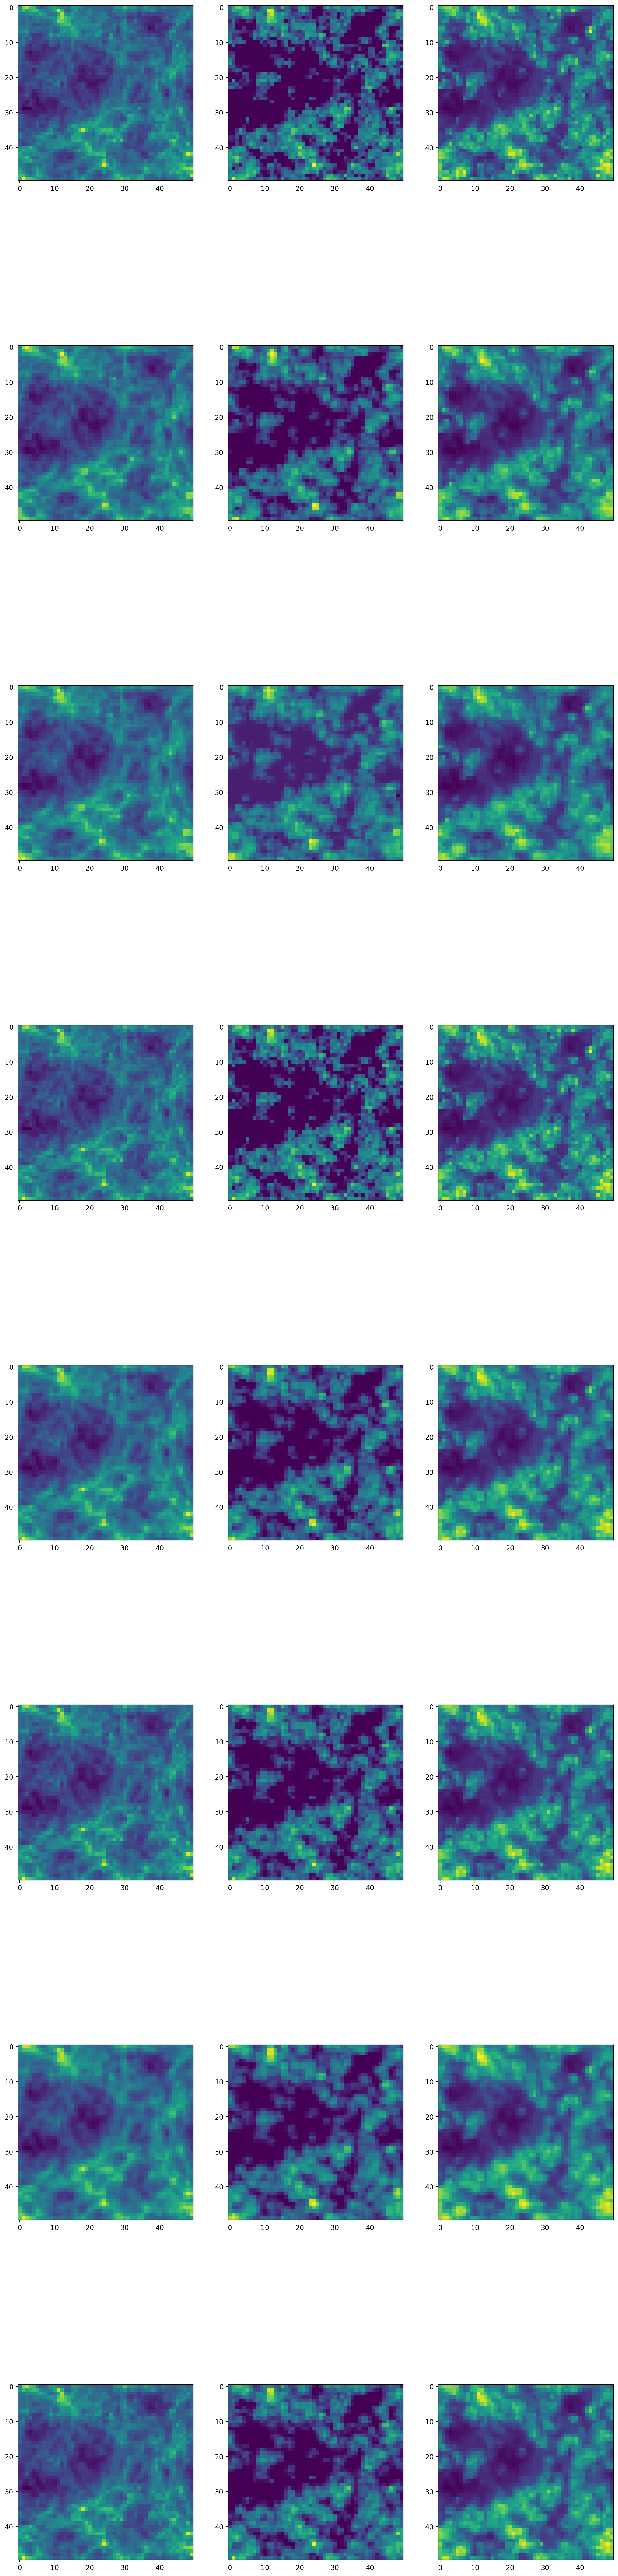

In [13]:
fig, ax = plt.subplots(8, quantities.shape[1], figsize=(16, 72))
for i in range(quantities.shape[1]):
    ax[0, i].imshow(np.log10(fields_ngp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[1, i].imshow(np.log10(fields_cic.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[2, i].imshow(np.log10(fields_tsc.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[3, i].imshow(np.log10(fields_ngp_cpp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[4, i].imshow(np.log10(fields_cic_cpp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[5, i].imshow(np.log10(fields_cic_ada_cpp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[6, i].imshow(np.log10(fields_tsc_cpp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[7, i].imshow(np.log10(fields_tsc_ada_cpp.mean(axis=0))[:, :, i])

plt.show()

/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/681485541.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0, i].imshow(np.log10(fields_sph_iso_cpp_1.mean(axis=0))[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/681485541.py:6: RuntimeWarning: invalid value encountered in log10
  ax[1, i].imshow(np.log10(fields_sph_iso_cpp_2.mean(axis=0))[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/681485541.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[1, i].imshow(np.log10(fields_sph_iso_cpp_2.mean(axis=0))[:, :, i])
/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_70404/681485541.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
 

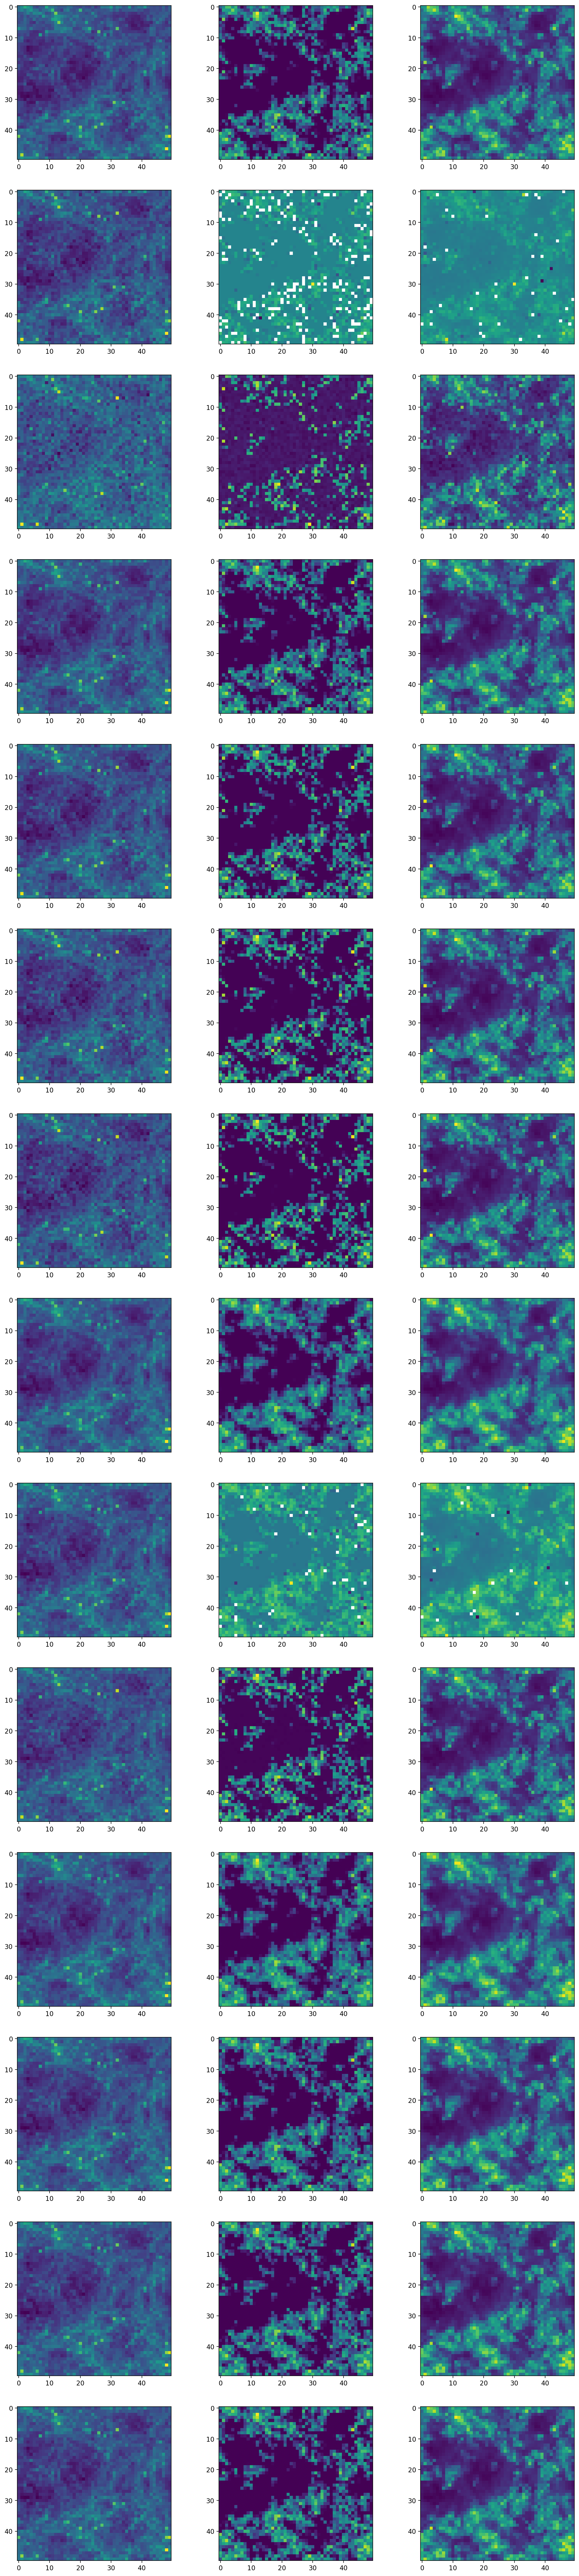

In [14]:
fig, ax = plt.subplots(14, quantities.shape[1], figsize=(16, 72))
for i in range(quantities.shape[1]):
    ax[0, i].imshow(np.log10(fields_sph_iso_cpp_1.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[1, i].imshow(np.log10(fields_sph_iso_cpp_2.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[2, i].imshow(np.log10(fields_sph_iso_cpp_3.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[3, i].imshow(np.log10(fields_sph_iso_cpp_4.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[4, i].imshow(np.log10(fields_sph_iso_cpp_5.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[5, i].imshow(np.log10(fields_sph_iso_cpp_6.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[6, i].imshow(np.log10(fields_sph_iso_cpp_7.mean(axis=0))[:, :, i])


for i in range(quantities.shape[1]):
    ax[7, i].imshow(np.log10(fields_sph_aniso_cpp_1.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[8, i].imshow(np.log10(fields_sph_aniso_cpp_2.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[9, i].imshow(np.log10(fields_sph_aniso_cpp_3.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[10, i].imshow(np.log10(fields_sph_aniso_cpp_4.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[11, i].imshow(np.log10(fields_sph_aniso_cpp_5.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[12, i].imshow(np.log10(fields_sph_aniso_cpp_6.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[13, i].imshow(np.log10(fields_sph_aniso_cpp_7.mean(axis=0))[:, :, i])
plt.show()

In [ ]:
raise SystemExit

SystemExit: 

/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 9))

for j in range(4):
    fov = np.s_[50:150, -100:]

    ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-4)
    ax[j, 1].imshow(fields[j][fov][...,1], cmap='twilight')
    ax[j, 2].imshow(np.log10(fields[j][fov][...,-2]), cmap='binary_r')
    ax[j, 3].imshow(np.log10(fields[j][fov][...,-1]), cmap='gist_heat')

for a in ax.flat:
    a.axis('off')

plt.tight_layout()
fig.savefig('plots/deposition_comparison.png', transparent=True, dpi=300)
plt.show()

We can plot the smoothing ellipses (projected 3d-ellipsoids to the plane) compared to the isotropic smoothing lengths (circles)

In [ ]:
from matplotlib.patches import Circle, Ellipse

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pos[:, 0], pos[:, 1], s=1, ec='none', alpha=0.5)

def draw_circle(ax, center, radius):
    circle = Circle(center, radius, 
                    fill=False, edgecolor='k', lw=1, alpha=0.5)
    ax.add_patch(circle)

def draw_ellipse(ax, center, width, height, angle):
    ellipse = Ellipse(center, width, height, angle=angle, 
                      fill=False, edgecolor='g', lw=1, alpha=0.8)
    ax.add_patch(ellipse)


for p, h, w, v in zip(pos[::250], 
                      hsm[::250], 
                      eλ_2d[::250], 
                      ev_2d[::250]):

    # Calculate width, height, and angle of the ellipse
    width, height = 2*w
    angle = np.degrees(np.arctan2(*v[:, 0][::-1]))

    # Draw the smoothing circle and ellipse
    center = (p[0], p[1])
    draw_circle(ax, center, h)
    draw_ellipse(ax, center, width, height, angle)
    